In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


 - Min class count:  976
Loaded 2928 images
Dataset type test label type: species


 - Min class count:  976
Loaded 17568 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 0qzdskm4


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-0qzdskm4:best, 314.55MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.8


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                               | 0/330 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                      | 1/330 [00:01<06:11,  1.13s/it]

  2%|██▋                                                                                                                                                    | 6/330 [00:01<00:50,  6.37it/s]

  3%|█████                                                                                                                                                 | 11/330 [00:01<00:25, 12.35it/s]

  5%|███████▎                                                                                                                                              | 16/330 [00:01<00:16, 18.50it/s]

  6%|█████████▌                                                                                                                                            | 21/330 [00:01<00:12, 24.41it/s]

  8%|███████████▊                                                                                                                                          | 26/330 [00:01<00:10, 29.78it/s]

  9%|██████████████                                                                                                                                        | 31/330 [00:01<00:08, 34.38it/s]

 11%|████████████████▎                                                                                                                                     | 36/330 [00:01<00:07, 38.18it/s]

 12%|██████████████████▋                                                                                                                                   | 41/330 [00:01<00:07, 41.16it/s]

 14%|████████████████████▉                                                                                                                                 | 46/330 [00:02<00:06, 43.45it/s]

 15%|███████████████████████▏                                                                                                                              | 51/330 [00:02<00:06, 45.15it/s]

 17%|█████████████████████████▍                                                                                                                            | 56/330 [00:02<00:05, 46.29it/s]

 18%|███████████████████████████▋                                                                                                                          | 61/330 [00:02<00:05, 47.21it/s]

 20%|██████████████████████████████                                                                                                                        | 66/330 [00:02<00:05, 47.87it/s]

 22%|████████████████████████████████▎                                                                                                                     | 71/330 [00:02<00:05, 48.31it/s]

 23%|██████████████████████████████████▌                                                                                                                   | 76/330 [00:02<00:05, 48.58it/s]

 25%|████████████████████████████████████▊                                                                                                                 | 81/330 [00:02<00:05, 48.80it/s]

 26%|███████████████████████████████████████                                                                                                               | 86/330 [00:02<00:04, 48.99it/s]

 28%|█████████████████████████████████████████▎                                                                                                            | 91/330 [00:02<00:04, 49.05it/s]

 29%|███████████████████████████████████████████▋                                                                                                          | 96/330 [00:03<00:04, 49.19it/s]

 31%|█████████████████████████████████████████████▌                                                                                                       | 101/330 [00:03<00:04, 49.22it/s]

 32%|███████████████████████████████████████████████▊                                                                                                     | 106/330 [00:03<00:04, 49.27it/s]

 34%|██████████████████████████████████████████████████                                                                                                   | 111/330 [00:03<00:04, 49.22it/s]

 35%|████████████████████████████████████████████████████▍                                                                                                | 116/330 [00:03<00:04, 49.29it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                              | 121/330 [00:03<00:04, 49.28it/s]

 38%|████████████████████████████████████████████████████████▉                                                                                            | 126/330 [00:03<00:04, 49.34it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                         | 131/330 [00:03<00:04, 49.39it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                       | 136/330 [00:03<00:03, 49.41it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                     | 141/330 [00:03<00:03, 49.40it/s]

 44%|█████████████████████████████████████████████████████████████████▉                                                                                   | 146/330 [00:04<00:03, 49.38it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                                | 151/330 [00:04<00:03, 49.43it/s]

 47%|██████████████████████████████████████████████████████████████████████▍                                                                              | 156/330 [00:04<00:03, 49.46it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                            | 161/330 [00:04<00:03, 49.45it/s]

 50%|██████████████████████████████████████████████████████████████████████████▉                                                                          | 166/330 [00:04<00:03, 49.47it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                       | 171/330 [00:04<00:03, 49.39it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                     | 176/330 [00:04<00:03, 49.33it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▋                                                                   | 181/330 [00:04<00:03, 49.36it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                 | 186/330 [00:04<00:02, 49.42it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                              | 191/330 [00:04<00:02, 49.42it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 196/330 [00:05<00:02, 49.20it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 201/330 [00:05<00:02, 49.28it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                        | 206/330 [00:05<00:02, 49.27it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 211/330 [00:05<00:02, 49.31it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 216/330 [00:05<00:02, 49.32it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 221/330 [00:05<00:02, 49.33it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 226/330 [00:05<00:02, 49.27it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 231/330 [00:05<00:02, 49.30it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 236/330 [00:05<00:01, 49.35it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 241/330 [00:05<00:01, 49.36it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 246/330 [00:06<00:01, 49.39it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 251/330 [00:06<00:01, 49.47it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 257/330 [00:06<00:01, 50.02it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 263/330 [00:06<00:01, 50.13it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 269/330 [00:06<00:01, 50.34it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 275/330 [00:06<00:01, 50.50it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 281/330 [00:06<00:00, 50.43it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 287/330 [00:06<00:00, 50.46it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 293/330 [00:07<00:00, 50.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 299/330 [00:07<00:00, 50.60it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 305/330 [00:07<00:00, 50.52it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 311/330 [00:07<00:00, 50.58it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 317/330 [00:07<00:00, 50.61it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 323/330 [00:07<00:00, 50.25it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 329/330 [00:07<00:00, 49.79it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [00:07<00:00, 42.26it/s]

train - OK


  0%|                                                                                                                                                                | 0/42 [00:00<?, ?it/s]

  2%|███▌                                                                                                                                                    | 1/42 [00:00<00:05,  7.79it/s]

 14%|█████████████████████▋                                                                                                                                  | 6/42 [00:00<00:01, 29.29it/s]

 26%|███████████████████████████████████████▌                                                                                                               | 11/42 [00:00<00:00, 37.71it/s]

 38%|█████████████████████████████████████████████████████████▌                                                                                             | 16/42 [00:00<00:00, 42.03it/s]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 21/42 [00:00<00:00, 44.41it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 26/42 [00:00<00:00, 45.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 31/42 [00:00<00:00, 46.94it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 36/42 [00:00<00:00, 47.62it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 41/42 [00:00<00:00, 48.01it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 40.83it/s]

val - OK


  0%|                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

  4%|██████▌                                                                                                                                                 | 1/23 [00:00<00:02,  7.49it/s]

 26%|███████████████████████████████████████▋                                                                                                                | 6/23 [00:00<00:00, 28.72it/s]

 48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 11/23 [00:00<00:00, 37.26it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 16/23 [00:00<00:00, 41.67it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 21/23 [00:00<00:00, 44.24it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.33it/s]

test InD - OK


  0%|                                                                                                                                                               | 0/138 [00:00<?, ?it/s]

  1%|█                                                                                                                                                      | 1/138 [00:00<00:18,  7.38it/s]

  4%|██████▌                                                                                                                                                | 6/138 [00:00<00:04, 28.51it/s]

  8%|███████████▉                                                                                                                                          | 11/138 [00:00<00:03, 36.97it/s]

 12%|█████████████████▍                                                                                                                                    | 16/138 [00:00<00:02, 41.48it/s]

 15%|██████████████████████▊                                                                                                                               | 21/138 [00:00<00:02, 44.10it/s]

 19%|████████████████████████████▎                                                                                                                         | 26/138 [00:00<00:02, 45.80it/s]

 22%|█████████████████████████████████▋                                                                                                                    | 31/138 [00:00<00:02, 46.93it/s]

 26%|███████████████████████████████████████▏                                                                                                              | 36/138 [00:00<00:02, 47.75it/s]

 30%|████████████████████████████████████████████▌                                                                                                         | 41/138 [00:00<00:02, 48.29it/s]

 33%|██████████████████████████████████████████████████                                                                                                    | 46/138 [00:01<00:01, 48.59it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                              | 51/138 [00:01<00:01, 48.87it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                         | 56/138 [00:01<00:01, 49.02it/s]

 44%|██████████████████████████████████████████████████████████████████▎                                                                                   | 61/138 [00:01<00:01, 49.08it/s]

 48%|███████████████████████████████████████████████████████████████████████▋                                                                              | 66/138 [00:01<00:01, 49.20it/s]

 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                        | 71/138 [00:01<00:01, 49.28it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                   | 76/138 [00:01<00:01, 49.25it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████                                                              | 81/138 [00:01<00:01, 49.29it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 86/138 [00:01<00:01, 49.34it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 91/138 [00:01<00:00, 49.32it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 96/138 [00:02<00:00, 49.34it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 101/138 [00:02<00:00, 49.34it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 106/138 [00:02<00:00, 49.24it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 111/138 [00:02<00:00, 49.34it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 116/138 [00:02<00:00, 49.32it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 121/138 [00:02<00:00, 49.33it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 126/138 [00:02<00:00, 49.35it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 131/138 [00:02<00:00, 49.40it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 136/138 [00:02<00:00, 49.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:02<00:00, 46.25it/s]

test OoD - OK


  0%|                                                                                                                                                               | 0/100 [00:00<?, ?it/s]

  6%|█████████                                                                                                                                              | 6/100 [00:00<00:01, 51.54it/s]

 12%|██████████████████                                                                                                                                    | 12/100 [00:00<00:01, 50.96it/s]

 18%|███████████████████████████                                                                                                                           | 18/100 [00:00<00:01, 50.90it/s]

 24%|████████████████████████████████████                                                                                                                  | 24/100 [00:00<00:01, 50.84it/s]

 30%|█████████████████████████████████████████████                                                                                                         | 30/100 [00:00<00:01, 50.82it/s]

 36%|██████████████████████████████████████████████████████                                                                                                | 36/100 [00:00<00:01, 50.85it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                       | 42/100 [00:00<00:01, 50.88it/s]

 48%|████████████████████████████████████████████████████████████████████████                                                                              | 48/100 [00:00<00:01, 50.89it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                     | 54/100 [00:01<00:00, 50.90it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 60/100 [00:01<00:00, 50.91it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 66/100 [00:01<00:00, 50.92it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 72/100 [00:01<00:00, 50.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 78/100 [00:01<00:00, 50.91it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 84/100 [00:01<00:00, 50.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 90/100 [00:01<00:00, 50.94it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:01<00:00, 50.92it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.90it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(42153, 3, 64, 64) (42153, 2048) (42153, 512) (42153, 2) (42153,)
(5269, 3, 64, 64) (5269, 2048) (5269, 512) (5269, 2) (5269,)
(2928, 3, 64, 64) (2928, 2048) (2928, 512) (2928, 2) (2928,)
(17568, 3, 64, 64) (17568, 2048) (17568, 512) (17568, 2) (17568,)
(12800, 3, 64, 64) (12800, 2048) (12800, 512) (12800, 2)


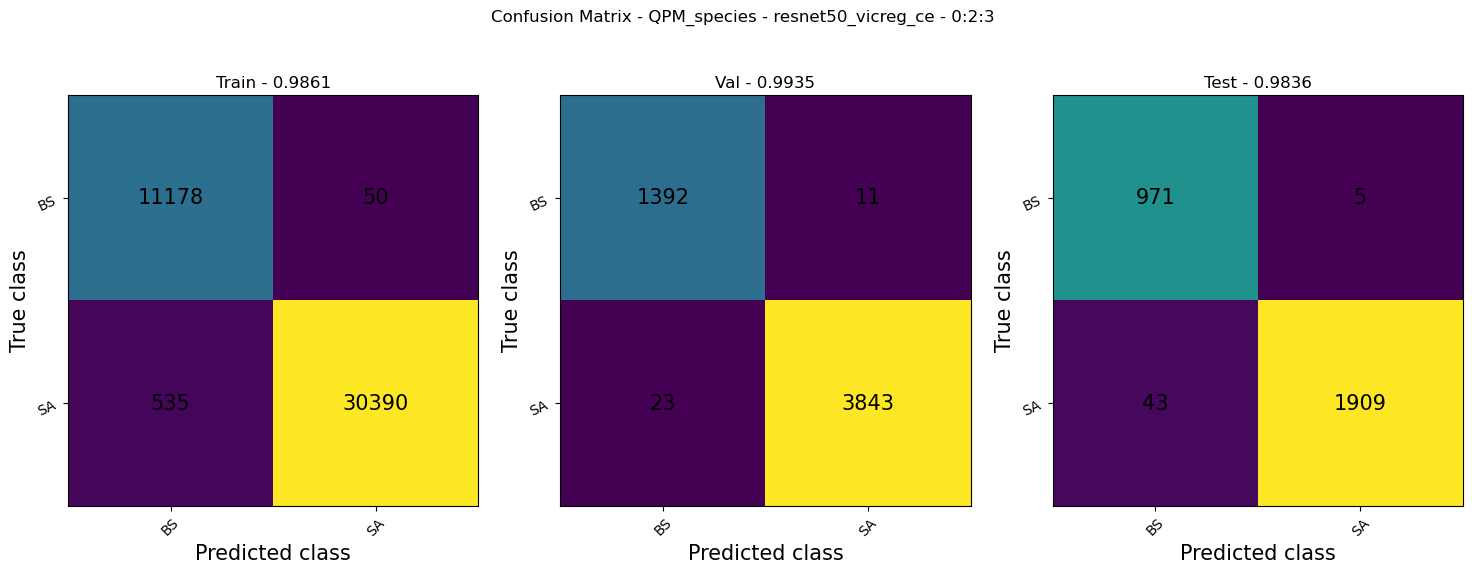

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_ftr2d = umap.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(2928, 2) (17568, 2)
(2928, 2) (17568, 2)


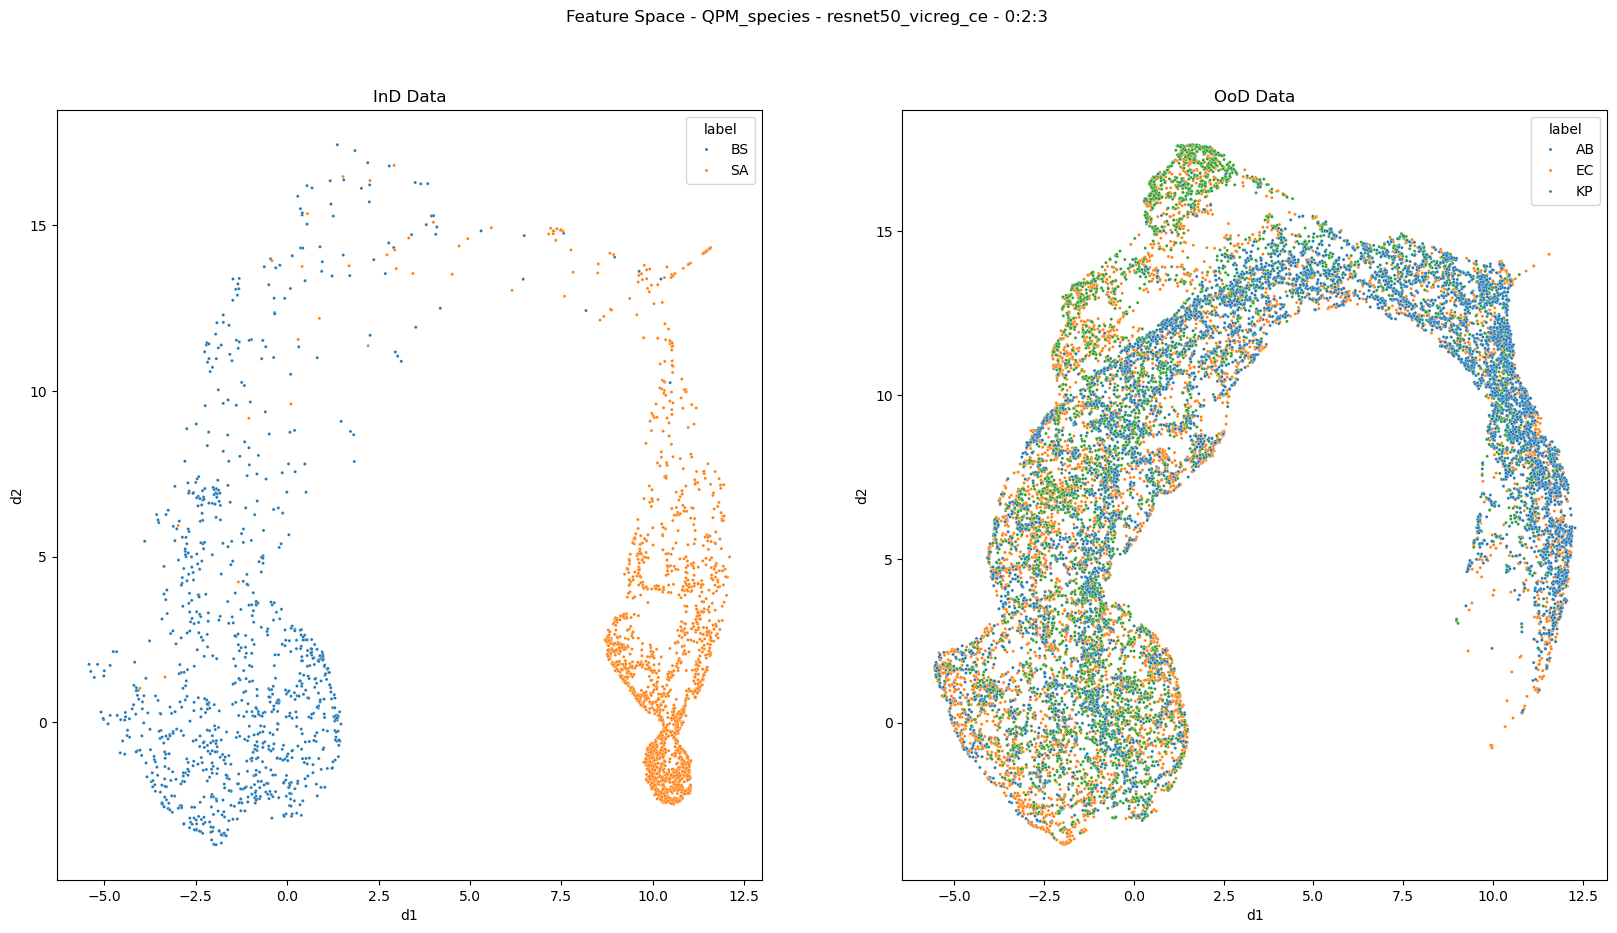

In [13]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

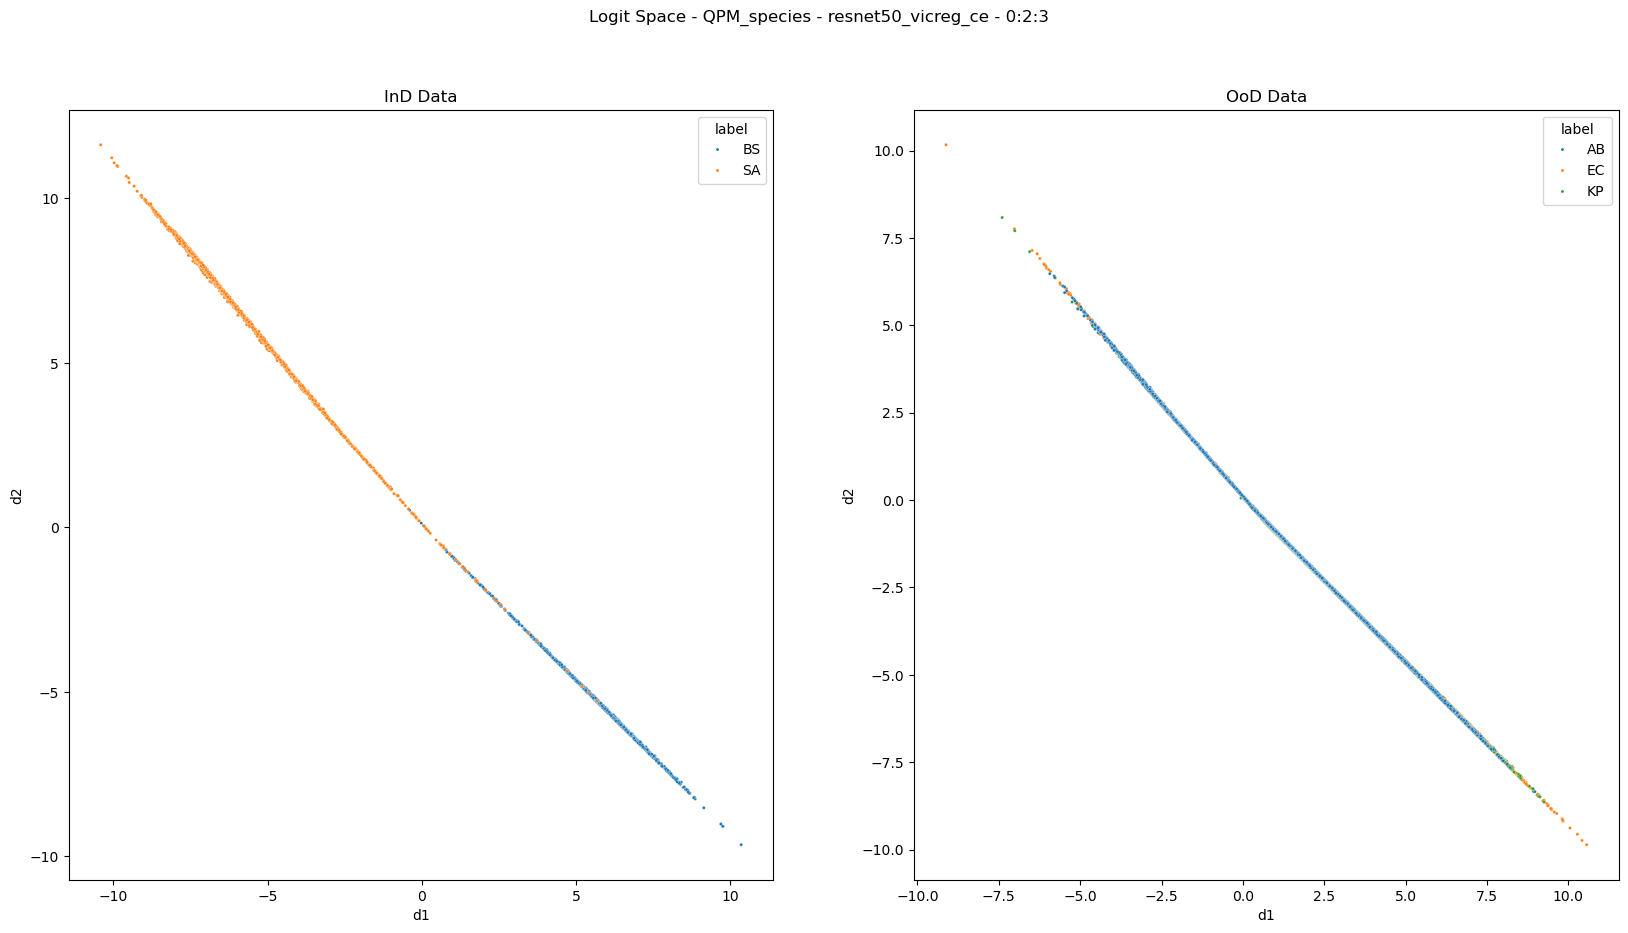

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

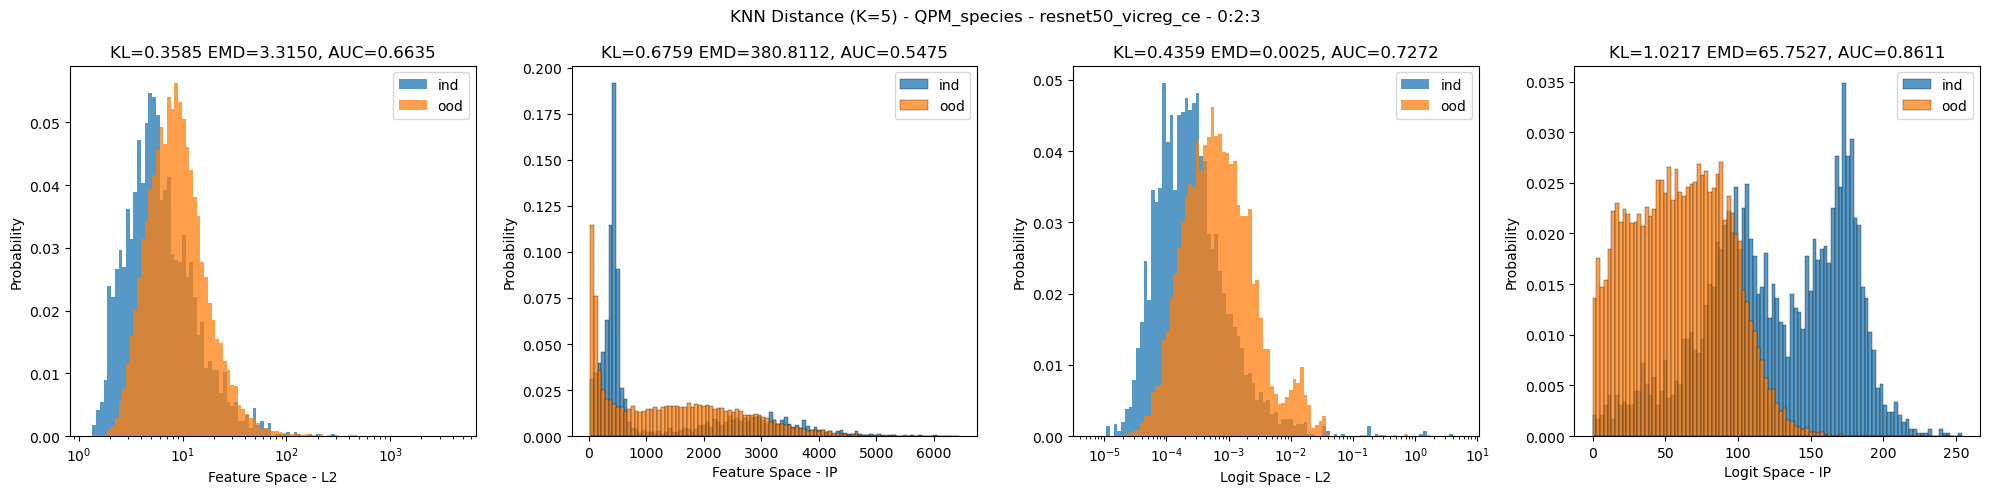

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

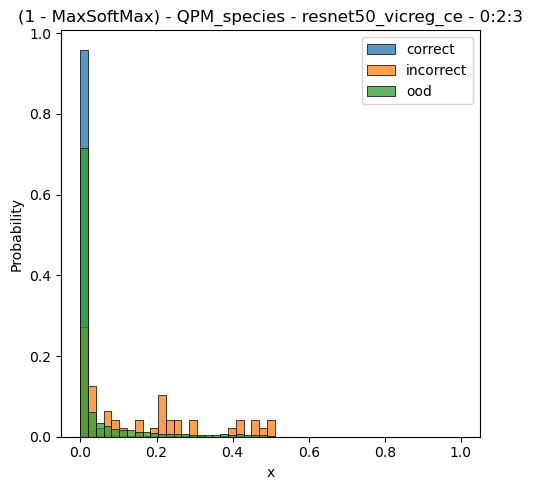

In [16]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [17]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)